# Vaex tutorial
## DataFrame
Central to vaex is the DataFrame (similar, but more efficient than a pandas dataframe), and we often use the variables `df` to represent it. A DataFrame is an efficient representation for large tabular data, and has:

 * A bunch of columns, say `x`, `y` and `z`
   * Backed by a numpy array, e.g. `df.data.x` (but you shouldn't work with this directly)
   * Wrapped by an expression system, e.g. `df.x`, `df['x']` or `df.col.x` is an expression
   * Columns/expression can perform lazy computations, e.g. `df.x * np.sin(df.y)` does nothing, until the result is needed
 * A set of virtual columns, columns that are backed by a (lazy) computation, e.g. `df['r'] = df.x/df.y` 
 * A set of selection, that can be used to explore the dataset, e.g. `df.select(df.x < 0)`
 * Filtered DataFrames, that does not copy the data, `df_negative = df[df.x < 0]`
 
Lets start with an example dataset, included in vaex

In [1]:
import vaex
df = vaex.example()
df  # begin the last statement it will print out the tabular data

#,x,y,z,vx,vy,vz,E,L,Lz,FeH
0,-0.777470767,2.10626292,1.93743467,53.276722,288.386047,-95.2649078,-121238.171875,831.0799560546875,-336.426513671875,-2.309227609164518
1,3.77427316,2.23387194,3.76209331,252.810791,-69.9498444,-56.3121033,-100819.9140625,1435.1839599609375,-828.7567749023438,-1.788735491591229
2,1.3757627,-6.3283844,2.63250017,96.276474,226.440201,-34.7527161,-100559.9609375,1039.2989501953125,920.802490234375,-0.7618109022478798
3,-7.06737804,1.31737781,-6.10543537,204.968842,-205.679016,-58.9777031,-70174.8515625,2441.724853515625,1183.5899658203125,-1.5208778422936413
4,0.243441463,-0.822781682,-0.206593871,-311.742371,-238.41217,186.824127,-144138.75,374.8164367675781,-314.5353088378906,-2.655341358427361
...,...,...,...,...,...,...,...,...,...,...
"329,995",3.76883793,4.66251659,-4.42904139,107.432999,-2.13771296,17.5130272,-119687.3203125,746.8833618164062,-508.96484375,-1.6499842518381402
"329,996",9.17409325,-8.87091351,-8.61707687,32.0,108.089264,179.060638,-68933.8046875,2395.633056640625,1275.490234375,-1.4336036247720836
"329,997",-1.14041007,-8.4957695,2.25749826,8.46711349,-38.2765236,-127.541473,-112580.359375,1182.436279296875,115.58557891845703,-1.9306227597361942
"329,998",-14.2985935,-5.51750422,-8.65472317,110.221558,-31.3925591,86.2726822,-74862.90625,1324.5926513671875,1057.017333984375,-1.225019818838568


### Columns
The above preview shows this dataset contains $> 300,000$ rows, and columns named x,y,z (positions), vx, vy, vz (velocities), E (energy), L (angular momentum). Printing out a column, shows it is not a numpy array, but an expression

In [2]:
df.x  # df.col.x or df['x'] are equivalent, but may be preferred because it is more tab completion friendly or programmatics friendly respectively

<vaex.expression.Expression(expressions='x')> instance at 0x117ac0438 values=[-0.777470767, 3.77427316, 1.3757627, -7.06737804, 0.243441463 ... (total 330000 values) ... 3.76883793, 9.17409325, -1.14041007, -14.2985935, 10.5450506] 

The underlying data is often accessible using `df.data.x`, but should not be used, since selections and filtering are not reflected in this. However sometimes it is useful to access the raw numpy array.

In [3]:
df.data.x

array([ -0.77747077,   3.77427316,   1.3757627 , ...,  -1.14041007,
       -14.2985935 ,  10.5450506 ])

A better way, if you need a numpy array (for instance for plotting, or passing to a different library) it to use evalulate, which will also work with virtual columns, selections and filtered DataFrames (more on that below).

In [4]:
df.evaluate(df.x)

array([ -0.77747077,   3.77427316,   1.3757627 , ...,  -1.14041007,
       -14.2985935 ,  10.5450506 ])

Most numpy function (ufuncs) can be performed on expressions, and will not result in a direct result, but in a new expression.

In [5]:
import numpy as np
np.sqrt(df.x**2 + df.y**2 + df.z**2)

<vaex.expression.Expression(expressions='sqrt((((x ** 2) + (y ** 2)) + (z ** 2)))')> instance at 0x116244cf8 values=[2.9655450396553587, 5.77829281049018, 6.99079603950256, 9.431842752707537, 0.8825613121347967 ... (total 330000 values) ... 7.453831761514681, 15.398412491068198, 8.864250273925633, 17.601047186042507, 14.540181524970293] 

### Virtual functions
Sometimes it is convenient to store an expression as a column, or virtual column, a column that does not take up memory, but will be computed on the fly. A virtual column can be treated as a normal column.

In [6]:
df['r'] = np.sqrt(df.x**2 + df.y**2 + df.z**2)
df[['x', 'y', 'z', 'r']]

#,x,y,z,r
0,-0.777470767,2.10626292,1.93743467,2.9655450396553587
1,3.77427316,2.23387194,3.76209331,5.77829281049018
2,1.3757627,-6.3283844,2.63250017,6.99079603950256
3,-7.06737804,1.31737781,-6.10543537,9.431842752707537
4,0.243441463,-0.822781682,-0.206593871,0.8825613121347967
...,...,...,...,...
"329,995",3.76883793,4.66251659,-4.42904139,7.453831761514681
"329,996",9.17409325,-8.87091351,-8.61707687,15.398412491068198
"329,997",-1.14041007,-8.4957695,2.25749826,8.864250273925633
"329,998",-14.2985935,-5.51750422,-8.65472317,17.601047186042507


### Selections and filtering
Vaex can be efficient when exploring subsets of the data, for instance to remove outlier or to inspect only a part of the data. Instead of making copies, internally vaex keeps track which rows are selected.

In [7]:
df.select(df.x < 0)
df.evaluate(df.x, selection=True)

array([ -0.77747077,  -7.06737804,  -5.17174435, ...,  -1.87310386,
        -1.14041007, -14.2985935 ])

Selections can be useful if you want to change what you select frequently, as in visualization, or when you want to compute statistics on several selections efficiently. Instead, you can also create a filtered dataset, and is similar in use to pandas, except that it does not copy the data. 

In [8]:
df_negative = df[df.x < 0]
df_negative[['x', 'y', 'z', 'r']]

#,x,y,z,r
0,-0.777470767,2.10626292,1.93743467,2.9655450396553587
1,-7.06737804,1.31737781,-6.10543537,9.431842752707537
2,-5.17174435,7.82915306,1.82668829,9.559255586471544
3,-15.9538851,5.77125883,-9.02472305,19.21664654397474
4,-12.3994961,13.9181805,-5.43482304,19.416502090763164
...,...,...,...,...
"165,935",-9.88553238,-6.59253597,6.53742027,13.561826747838182
"165,936",-2.38018084,4.73540306,0.141765863,5.301829922929686
"165,937",-1.87310386,-0.503091216,-0.951977015,2.1605275001840565
"165,938",-1.14041007,-8.4957695,2.25749826,8.864250273925633


## Statistics on N-d grids
A core feature of vaex, and used for visualization, is calculation of statistics on N dimensional grid.

In [9]:
df.count(), df.mean(df.x), df.mean(df.x, selection=True)

(array(330000.), -0.06713149126400597, -5.211037972111967)

Similar to SQL's groupby, vaex uses the binby concept, which tells vaex that a statistic should be calculated on a regular grid (for performance reasons)

In [10]:
xcounts = df.count(binby=df.x, limits=[-10, 10], shape=64)
xcounts

array([1310., 1416., 1452., 1519., 1599., 1810., 1956., 2005., 2157.,
       2357., 2653., 2786., 3012., 3215., 3619., 3890., 3973., 4400.,
       4782., 5126., 5302., 5729., 6042., 6562., 6852., 7167., 7456.,
       7633., 7910., 8415., 8619., 8246., 8358., 8769., 8294., 7870.,
       7749., 7389., 7174., 6901., 6557., 6173., 5721., 5367., 4963.,
       4655., 4246., 4110., 3939., 3611., 3289., 3018., 2811., 2570.,
       2505., 2267., 2013., 1803., 1687., 1563., 1384., 1326., 1257.,
       1189.])

This results in a numpy array with the number counts in 64 bins distributed between x = -10, and x = 10. We can quickly visualize this using matplotlib.

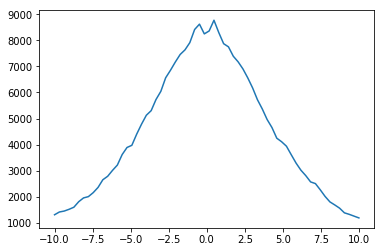

In [11]:
import matplotlib.pylab as plt
plt.plot(np.linspace(-10, 10, 64), xcounts)
plt.show()

We can instead of doing 1d binning, do it in 2d as well (N-d actually), and visualize it using imshow.

In [12]:
xycounts = df.count(binby=[df.x, df.y], limits=[[-10, 10], [-10, 20]], shape=(64, 128))
xycounts

array([[ 9.,  3.,  3., ...,  3.,  2.,  1.],
       [ 5.,  3.,  1., ...,  1.,  3.,  3.],
       [11.,  3.,  2., ...,  1.,  1.,  4.],
       ...,
       [12.,  6.,  8., ...,  0.,  1.,  0.],
       [ 7.,  6., 12., ...,  3.,  0.,  0.],
       [11., 10.,  7., ...,  1.,  1.,  1.]])

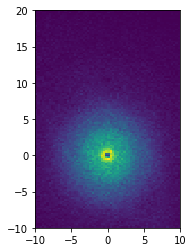

In [13]:
plt.imshow(xycounts.T, origin='lower', extent=[-10, 10, -10, 20])
plt.show()

In [14]:
v = np.sqrt(df.vx**2 + df.vy**2 + df.vz**2)
xy_mean_v = df.mean(v, binby=[df.x, df.y], limits=[[-10, 10], [-10, 20]], shape=(64, 128))
xy_mean_v

array([[144.38495511, 183.45775869, 187.78325557, ..., 138.99392387,
        168.66141282, 142.55018784],
       [143.72427758, 152.14679337, 107.90949865, ..., 119.65318885,
         94.00098292, 104.35109636],
       [172.08240652, 137.47896886,  72.51331138, ..., 179.85933835,
         33.36968912, 111.81826254],
       ...,
       [186.56949934, 161.3747346 , 174.27411865, ...,          nan,
        105.96746091,          nan],
       [179.55997022, 137.48979882, 113.82121826, ..., 104.90205692,
                 nan,          nan],
       [151.94323763, 135.44083212,  84.81787495, ..., 175.79289144,
        129.63799565, 108.19069385]])

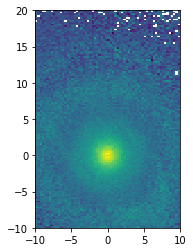

In [15]:
plt.imshow(xy_mean_v.T, origin='lower', extent=[-10, 10, -10, 20])
plt.show()

Other statistics can be computed, such as:

* [DataFrame.count](api.rst#vaex.dataframe.DataFrame.count)
* [DataFrame.mean](api.rst#vaex.dataframe.DataFrame.mean)
* [DataFrame.std](api.rst#vaex.dataframe.DataFrame.std)
* [DataFrame.var](api.rst#vaex.dataframe.DataFrame.var)
* [DataFrame.median_approx](api.rst#vaex.dataframe.DataFrame.median_approx)
* [DataFrame.percentile_approx](api.rst#vaex.dataframe.DataFrame.percentile_approx)
* [DataFrame.mode](api.rst#vaex.dataframe.DataFrame.mode)
* [DataFrame.min](api.rst#vaex.dataframe.DataFrame.min)
* [DataFrame.max](api.rst#vaex.dataframe.DataFrame.max)
* [DataFrame.minmax](api.rst#vaex.dataframe.DataFrame.minmax)
* [DataFrame.mutual_information](api.rst#vaex.dataframe.DataFrame.mutual_information)
* [DataFrame.correlation](api.rst#vaex.dataframe.DataFrame.correlation)

Or see the full list at the [API docs](api.rst#statistics)

## Getting your data in
Before continuing, you may want to read in your own data. Ultimately, a vaex DataFrame just wraps a set of numpy arrays. If you can access your data as a set of numpy arrays, you can therefore make 
dataset using [from_arrays](api.rst#vaex.from_arrays)

In [17]:
import vaex
import numpy as np
x = np.arange(5)
y = x**2
df = vaex.from_arrays(x=x, y=y)
df

#,x,y
0,0,0
1,1,1
2,2,4
3,3,9
4,4,16


Other quick ways to get your data in are:
 
  * [from_arrow_table](api.rst#vaex.from_arrow_table): [Arrow](https://arrow.apache.org/) table support.
  * [from_csv](api.rst#vaex.from_csv): Comma separated files
  * [from_ascii](api.rst#vaex.from_ascii): Space/tab separated files
  * [from_pandas](api.rst#vaex.from_pandas): Converts a pandas DataFrame
  * [from_astropy_table](api.rst#vaex.from_astropy_table): Converts an astropy table

Exporting, or converting a DataFrame to a different datastructure is also quite easy:
 
 * [DataFrame.to_arrow_table](api.rst#vaex.dataframe.DataFrame.to_arrow_table)
 * [DataFrame.to_dask_array](api.rst#vaex.dataframe.DataFrame.to_dask_array) 
 * [DataFrame.to_pandas_df](api.rst#vaex.dataframe.DataFrame.to_pandas_df)
 * [DataFrame.export](api.rst#vaex.dataframe.DataFrameLocal.export)
 * [DataFrame.export_hdf5](api.rst#vaex.dataframe.DataFrameLocal.export_hdf5)
 * [DataFrame.export_arrow](api.rst#vaex.dataframe.DataFrameLocal.export_arrow)
 * [DataFrame.export_fits](api.rst#vaex.dataframe.DataFrameLocal.export_fits)
 

## Plotting
### 1d and 2d
Most visualization can be done in 1 and 2d, and vaex wraps matplotlib to provide most use cases.

In [18]:
import vaex
import numpy as np
df = vaex.example()
%matplotlib inline

The simplest visualization is a 1d plot using [DataFrame.plot1d](api.rst#vaex.dataframe.DataFrame.plot1d). When only given one argument, it will show a histogram showing 99.8% of the data.

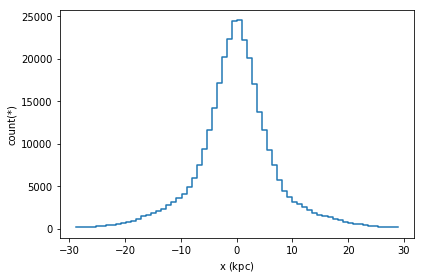

In [19]:
df.plot1d(df.x)

A slighly more complication visualization, is to not plot the counts, but a different statistic for that bin. In most cases, passing the `what='<statistic>(<expression>)` argument will do, where `<statistic>` is any of the statistics mentioned in the list above, or in the [API docs](api.rst#statistics)

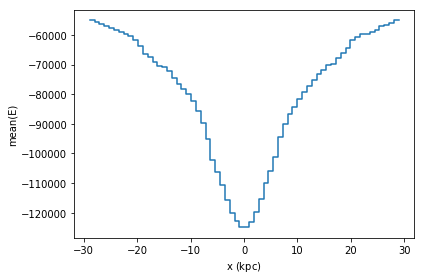

In [20]:
df.plot1d(df.x, what='mean(E)')

An equivalent method, is to use the `vaex.stat.<statistic>` functions, e.g. [vaex.stat.mean](api.rst#vaex.stat.mean)

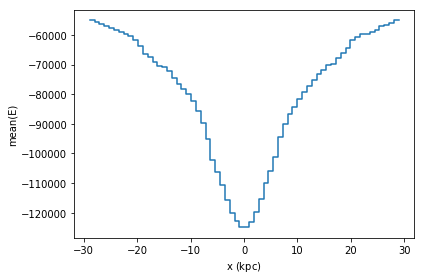

In [21]:
df.plot1d(df.x, what=vaex.stat.mean(df.E))

These objects are very similar to vaex' expression, in that they represent an underlying calculation, while normal arithmetic and numpy functions can be applied to it. However, these objects represent a statistics computation, and not a column.

In [22]:
np.log(vaex.stat.mean(df.x)/vaex.stat.std(df.x))

log((mean(x) / std(x)))

These statistical objects can be passed to the `what` argument. The advantage being that the data will only have to be passed over once.

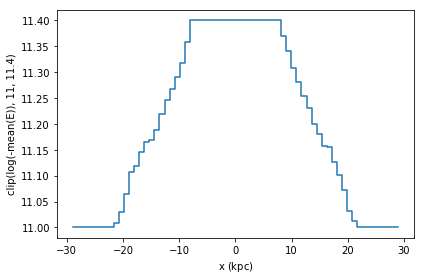

In [23]:
df.plot1d(df.x, what=np.clip(np.log(-vaex.stat.mean(df.E)), 11, 11.4))

A similar result can be obtained by calculating the statistic ourselves, and passing it to plot1d's grid argument. Care has to be taken that the limits used for calculating the statistics and the plot are the same, otherwise the x axis may not correspond to the real data.

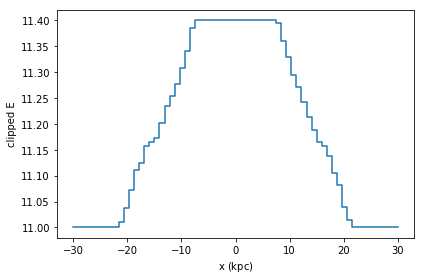

In [24]:
limits = [-30, 30]
shape  = 64
meanE  = df.mean(df.E, binby=df.x, limits=limits, shape=shape)
grid   = np.clip(np.log(-meanE), 11, 11.4)
df.plot1d(df.x, grid=grid, limits=limits, ylabel='clipped E')

The same applies for 2d plotting.

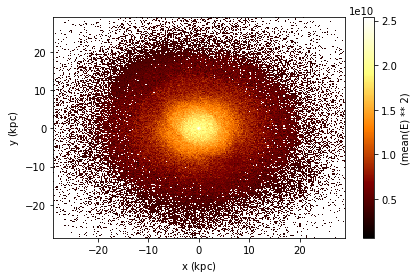

In [25]:
df.plot(df.x, df.y, what=vaex.stat.mean(df.E)**2)

### Selections for plotting
While filtering is useful for narrowing down a selection (e.g. `df_negative = df[df.x < 0]`) there are a few downsides to this. First, a practical issue is that when you filter 4 different ways, you will need to have 4 different objects, polluting your namespace. However, more importantly, when vaex executes a bunch of statistical computations, it will do that per DataFrame, meaning for 4 different DataFrames (although pointing to the same underlying data) it will do a total of 4 passes over the data.
If instead, we have 4 (named) selections in our dataset, it can calculate statistics in one single pass over the data, which can speed up especially when your dataset is larger than your memory.

In the plot below, we show three selection, which by default are blended together, requiring just one pass over the data.

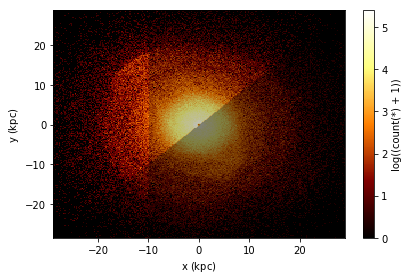

In [26]:
df.plot(df.x, df.y, what=np.log(vaex.stat.count()+1),
       selection=[None, df.x < df.y, df.x < -10])

### Advanced Plotting
Lets say we would like to see two plots next to eachother, we can pass a list of expression pairs.

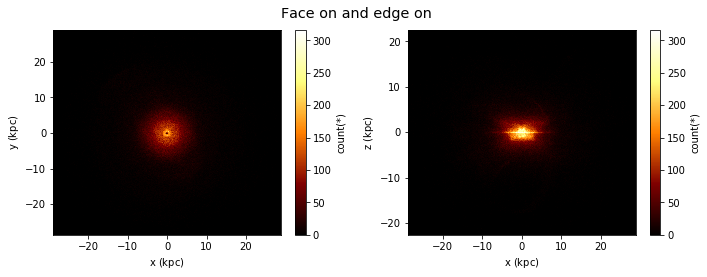

In [27]:
df.plot([["x", "y"], ["x", "z"]],
        title="Face on and edge on", figsize=(10,4));

By default, if you have multiple plots, they are shown as columns, multiple selections are overplotted, and multiple 'whats' (statistics) are shown as rows.

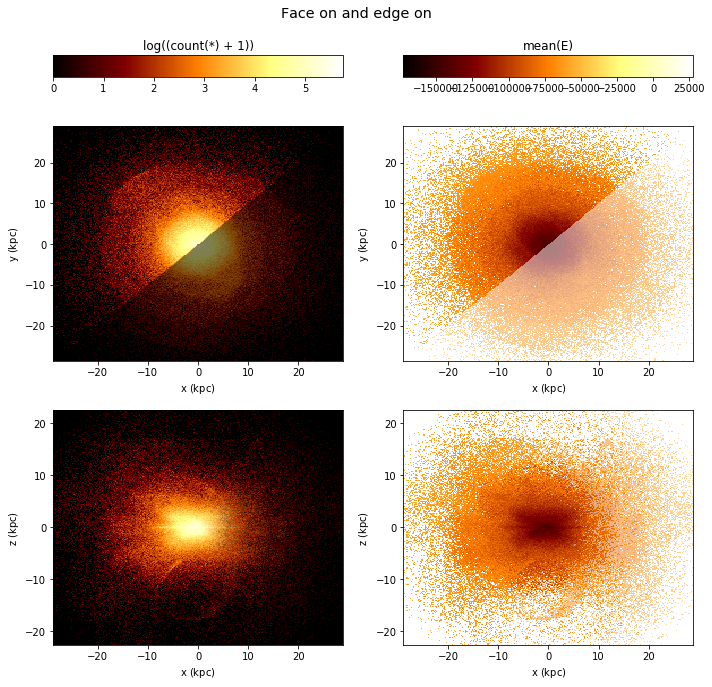

In [28]:
df.plot([["x", "y"], ["x", "z"]],
        what=[np.log(vaex.stat.count()+1), vaex.stat.mean(df.E)],
        selection=[None, df.x < df.y],
        title="Face on and edge on", figsize=(10,10));

(Note that the selection has no effect in the bottom rows)

However, this behaviour can be changed using the `visual` argument.

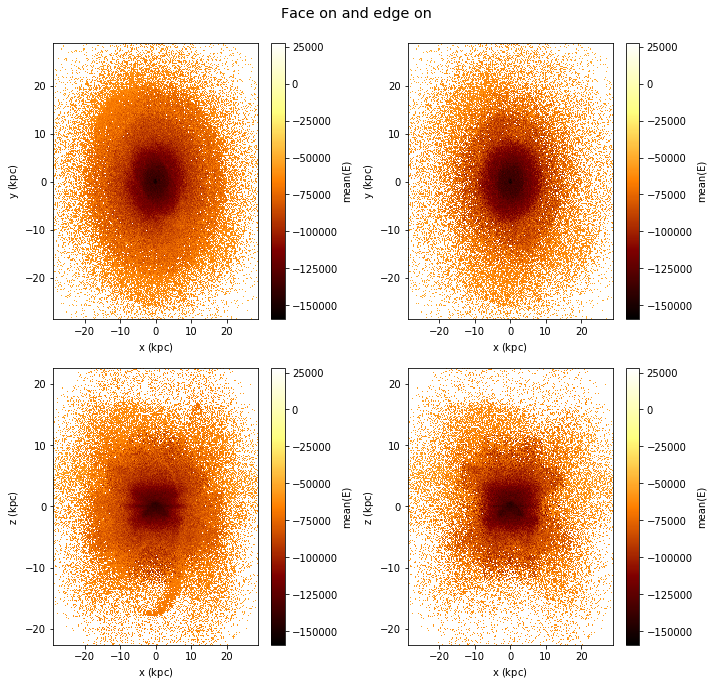

In [29]:
df.plot([["x", "y"], ["x", "z"]],
        what=vaex.stat.mean(df.E),
        selection=[None, df.Lz < 0],
        visual=dict(column='selection'),
        title="Face on and edge on", figsize=(10,10));

### Slices in a 3rd dimension
If a 3rd axis (z) is given, you can 'slice' through the data, displaying the z slices as rows. Note that here the rows are wrapped, which can be changed using the `wrap_columns` argument.

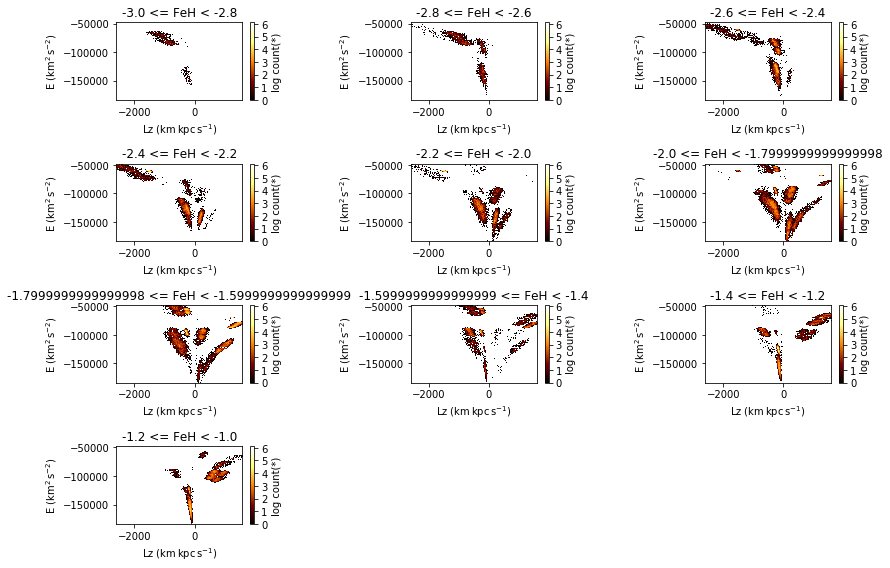

In [30]:
df.plot("Lz", "E", z="FeH:-3,-1,10", show=True, visual=dict(row="z"),
        figsize=(12,8), f="log", wrap_columns=3);

### Smaller datasets / scatter plot
Although vaex focuses on large datasets, sometimes you end up with a fraction of the data (due to a selection) and you want to make a scatter plot. You could try the following approach:

In [31]:
import vaex
df = vaex.example()
%matplotlib inline

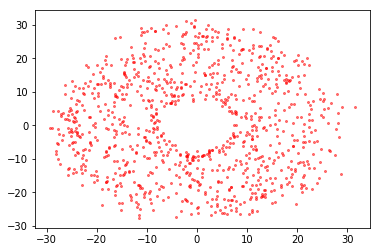

In [32]:
import matplotlib.pylab as plt
x = df.evaluate("x", selection=df.Lz < -2500)
y = df.evaluate("y", selection=df.Lz < -2500)
plt.scatter(x, y, c="red", alpha=0.5, s=4);

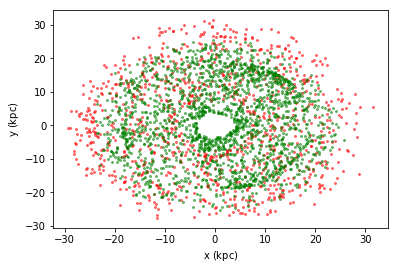

In [33]:
df.scatter(df.x, df.y, selection=df.Lz < -2500, c="red", alpha=0.5, s=4)
df.scatter(df.x, df.y, selection=df.Lz > 1500, c="green", alpha=0.5, s=4);

### In control
While vaex provides a wrapper for matplotlib, there are situations where you want to use the [DataFrame.plot](api.rst#vaex.dataframe.DataFrame.plot) method, but want to be in control of the plot. Vaex simply uses the current figure and axes, so that it is easy to do.

In [34]:
import numpy as np

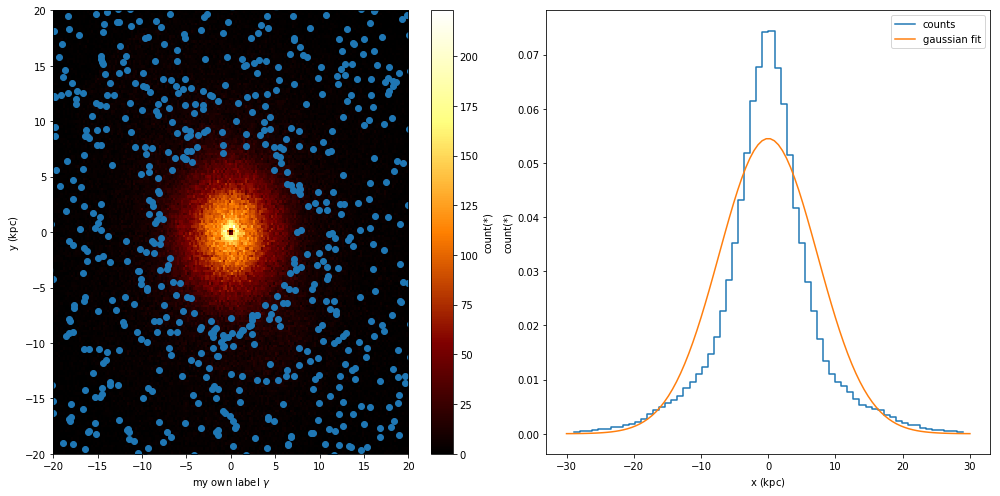

In [35]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14,7))
plt.sca(ax1)
selection = df.Lz < -2500
x = df[selection].x.evaluate()#selection=selection)
y = df[selection].y.evaluate()#selection=selection)
df.plot(df.x, df.y)
plt.scatter(x, y)
plt.xlabel('my own label $\gamma$')
plt.xlim(-20, 20)
plt.ylim(-20, 20)

plt.sca(ax2)
df.plot1d(df.x, label='counts', n=True)
x = np.linspace(-30, 30, 100)
std = df.std(df.x.expression)
y = np.exp(-(x**2/std**2/2)) / np.sqrt(2*np.pi) / std
plt.plot(x, y, label='gaussian fit')
plt.legend()

### Healpix (Plotting)
[healpix](https://en.wikipedia.org/wiki/HEALPix) is made available by the vaex-healpix package using the [healpy](https://healpy.readthedocs.io) package. Vaex does not need special support for healpix, only for plotting, but some helper functions are introduced to make working with healpix easier. By diving the source_id by 34359738368 you get a healpix index level 12, and diving it further will take you to lower levels.
 
To understand healpix better, we will start from the beginning. If we want to make a density sky plot, we would like to pass healpy a 1d numpy array where each value represents the density at a location of the sphere, where the location is determined by the array size (the healpix level) and the offset (the location). Since the Gaia data includes the healpix index encoded in the `source_id`. By diving the source_id by 34359738368 you get a healpix index level 12, and diving it further will take you to lower levels.



In [36]:
import vaex
import healpy as hp
%matplotlib inline
tgas = vaex.datasets.tgas.fetch()

We will start showing how you could manually do statistics on healpix bins using vaex.count. We will do a really course healpix scheme (level 2).

In [37]:
level = 2
factor = 34359738368 * (4**(12-level))
nmax = hp.nside2npix(2**level)
epsilon = 1e-16
counts = tgas.count(binby=tgas.source_id/factor, limits=[-epsilon, nmax-epsilon], shape=nmax)
counts

array([ 4021.,  6171.,  5318.,  7114.,  5755., 13420., 12711., 10193.,
        7782., 14187., 12578., 22038., 17313., 13064., 17298., 11887.,
        3859.,  3488.,  9036.,  5533.,  4007.,  3899.,  4884.,  5664.,
       10741.,  7678., 12092., 10182.,  6652.,  6793., 10117.,  9614.,
        3727.,  5849.,  4028.,  5505.,  8462., 10059.,  6581.,  8282.,
        4757.,  5116.,  4578.,  5452.,  6023.,  8340.,  6440.,  8623.,
        7308.,  6197., 21271., 23176., 12975., 17138., 26783., 30575.,
       31931., 29697., 17986., 16987., 19802., 15632., 14273., 10594.,
        4807.,  4551.,  4028.,  4357.,  4067.,  4206.,  3505.,  4137.,
        3311.,  3582.,  3586.,  4218.,  4529.,  4360.,  6767.,  7579.,
       14462., 24291., 10638., 11250., 29619.,  9678., 23322., 18205.,
        7625.,  9891.,  5423.,  5808., 14438., 17251.,  7833., 15226.,
        7123.,  3708.,  6135.,  4110.,  3587.,  3222.,  3074.,  3941.,
        3846.,  3402.,  3564.,  3425.,  4125.,  4026.,  3689.,  4084.,
      

And using healpy's [mollview](https://healpy.readthedocs.io/en/latest/generated/healpy.visufunc.mollview.html#healpy.visufunc.mollview) we can visualize this.

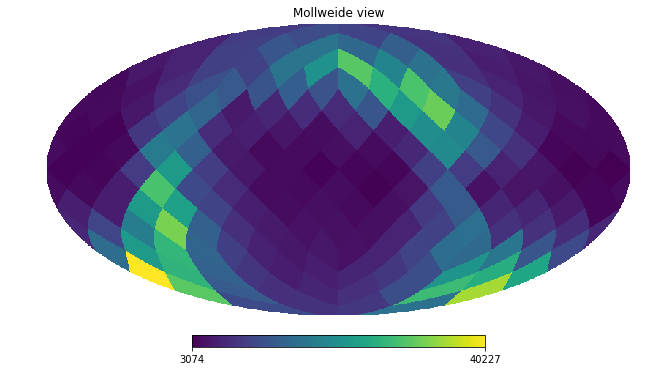

In [38]:
hp.mollview(counts, nest=True)

To simplify life, vaex includes [DataFrame.healpix_count](api.rst#vaex.dataframe.DataFrame.healpix_count) to take care of this.

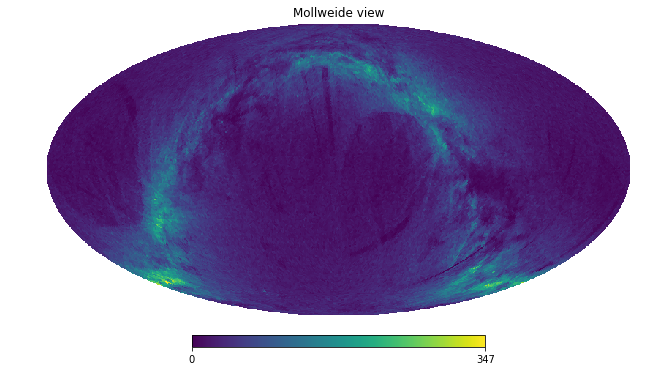

In [39]:
counts = tgas.healpix_count(healpix_level=6)
hp.mollview(counts, nest=True)

Or even simpler, use [DataFrame.healpix_plot](api.rst#vaex.dataframe.DataFrame.healpix_plot)

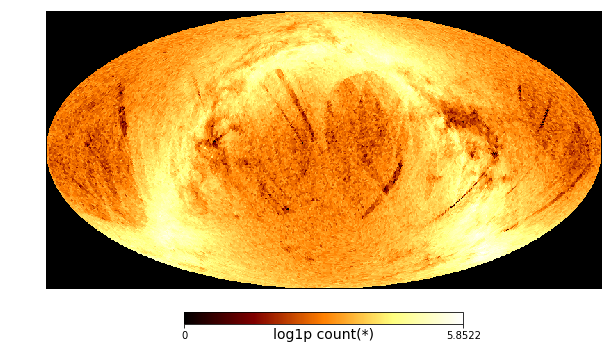

In [40]:
tgas.healpix_plot(f="log1p", healpix_level=6, figsize=(10,8),
                  healpix_output="ecliptic")

## Propagation of uncertainties
In science we often deal with measurement uncertainties (sometimes refererred to as measurement errors). When transformations are made with quantities that have uncertainties associated with them, the uncertainties on these transformed quantities can be calculated automatically by vaex. Note that propagation of uncertainties requires derivatives and matrix multiplications of lengthy equations, which is not complex, but tedious. Vaex can automatically calculate all dependencies, derivatives and compute the full covariance matrix.

In [41]:
import vaex
import pylab as plt
%matplotlib inline
tgas = vaex.datasets.tgas_1percent.fetch()

Even though the TGAS dataset already contains galactic sky coordiantes (l and b), we add them again as virtual columns such that the transformation between RA. and Dec. and the galactic sky coordinates is known.

In [42]:
# convert parallas to distance
tgas.add_virtual_columns_distance_from_parallax(tgas.parallax)
# 'overwrite' the real columns 'l' and 'b' with virtual columns
tgas.add_virtual_columns_eq2gal('ra', 'dec', 'l', 'b')
# and combined with the galactic sky coordinates gives galactic cartesian coordinates of the stars
tgas.add_virtual_columns_spherical_to_cartesian(tgas.l, tgas.b, tgas.distance, 'x', 'y', 'z')

j2000


Since RA. and Dec. are in degrees, while ra_error and dec_error are in miliarcseconds, we put them on the same scale

In [43]:
tgas['ra_error'] = tgas.ra_error / 1000 / 3600
tgas['dec_error'] = tgas.dec_error / 1000 / 3600

We now let vaex sort out what the covariance matrix is for the cartesian coordinates x, y, and z. And take 50 samples from the datasets for visualization.

In [44]:
tgas.propagate_uncertainties([tgas.x, tgas.y, tgas.z])
tgas_50 = tgas.sample(50, random_state=42)

For this small dataset we visualize the uncertainties, with and without the covariance.

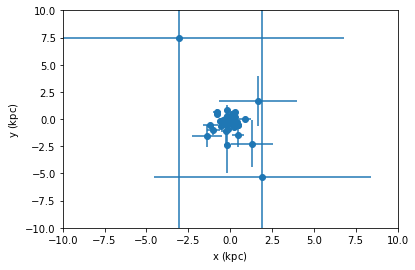

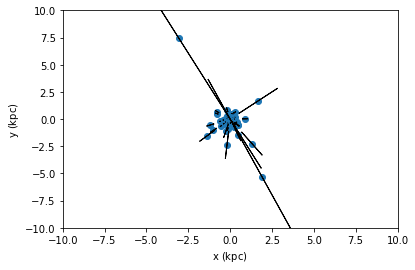

In [45]:
tgas_50.scatter(tgas_50.x, tgas_50.y, xerr=tgas_50.x_uncertainty, yerr=tgas_50.y_uncertainty)
plt.xlim(-10, 10)
plt.ylim(-10, 10)
plt.show()
tgas_50.scatter(tgas_50.x, tgas_50.y, xerr=tgas_50.x_uncertainty, yerr=tgas_50.y_uncertainty, cov=tgas_50.y_x_covariance)
plt.xlim(-10, 10)
plt.ylim(-10, 10)
plt.show()

From the second plot, we see that showing error ellipses (so narrow that they appear as lines) instead of error bars reveal that the distance information dominates the uncertainty in this case.

## Parallel computations
As mentioned in the sections on selections, vaex can do computations on a DataFrame in parallel. Often this is taken care of, when for instance passing multiple selections, or multiple arguments to one of the statistical functions. However, sometimes it is difficult or impossible to express a computation in one expression, and we need to resort to doing so called 'delayed' computation, similar as in [joblib](https://pythonhosted.org/joblib) and [dask](https://dask.pydata.org).

In [46]:
import vaex
df = vaex.example()
limits = [-10, 10]
delayed_count = df.count(df.E, binby=df.x, limits=limits,
                         shape=4, delay=True)
delayed_count

Note that now the returned value is not a promise (TODO: a more Pythonic way would be to return a Future). This may be subject to change, and the best way to work with this is to use the [delayed](api.rst#vaex.delayed) decorator. And call [DataFrame.execute](api.rst#vaex.dataframe.DataFrame.execute) when the result is needed.

In addition to the above delayed computation, we schedule another computation, such that both the count and mean are executed in parallel such that we only do a single pass over the data. We schedule the execution of two extra functions using the `vaex.delayed` decorator, and run the whole pipeline using `df.execute()`.

In [47]:
delayed_sum = df.sum(df.E, binby=df.x, limits=limits,
                         shape=4, delay=True)

@vaex.delayed
def calculate_mean(sums, counts):
    print('calculating mean')
    return sums/counts

print('before calling mean')
# since calculate_mean is decorated with vaex.delayed
# this now also returns a 'delayed' object (a promise)
delayed_mean = calculate_mean(delayed_sum, delayed_count)

# if we'd like to perform operations on that, we can again
# use the same decorator
@vaex.delayed
def print_mean(means):
    print('means', means)
print_mean(delayed_mean)

print('before calling execute')
df.execute()

# Using the .get on the promise will also return the resut
# However, this will only work after execute, and may be
# subject to change
means = delayed_mean.get()
print('same means', means)


before calling mean
before calling execute
calculating mean
means [ -94415.16581227 -118856.63989386 -118919.86423543  -95000.5998913 ]
same means [ -94415.16581227 -118856.63989386 -118919.86423543  -95000.5998913 ]


## Interactive widgets

<div class="alert alert-info">

**Note:** The interactive widgets require a running Python kernel, if you are viewing this documentation online you can get a feeling for what the widgets can do, but computation will not be possible!

</div>

Using the `vaex-jupyter` package, we get access to interactive widgets.

In [48]:
import vaex
import vaex.jupyter
import numpy as np
import pylab as plt
%matplotlib inline
df = vaex.example()

The simplest way to get a more interactive visualization (or even print out statistics) is to use the `vaex.jupyter.interactive_selection` decorator, which will execute the decorated function each time the selection is changed.


In [50]:
df.select(df.x > 0)
@vaex.jupyter.interactive_selection(df)
def plot():
    print("Mean x for the selection is:", df.mean(df.x, selection=True))
    df.plot(df.x, df.y, what=np.log(vaex.stat.count()+1), selection=[None, True])
    plt.show()

Output()

After changing the selection programmatically, the visualization will update, as well as the print output.

In [51]:
df.select(df.x > df.y)

However, to get truly interactive visualization, we need to use widgets, such as the [bqplot](https://github.com/bloomberg/bqplot) library. Again, if we make a selection here, the above visualization will also update, so lets select a square region.
One issue is that if you have installed ipywidget, bqplot, ipyvolume etc, it may not be enabled if you installed them from pip (installing from conda-forge will enable it automagically). To enable it, run the next cell, and refresh the notebook if they were not enabled already. *(Note that these commands will execute in the environment where the notebook is running, not where the kernel is running)*

In [52]:
import sys
!jupyter nbextension enable --sys-prefix --py widgetsnbextension
!jupyter nbextension enable --sys-prefix --py bqplot
!jupyter nbextension enable --sys-prefix --py ipyvolume
!jupyter nbextension enable --sys-prefix --py ipympl
!jupyter nbextension enable --sys-prefix --py ipyleaflet


Enabling notebook extension jupyter-js-widgets/extension...
      - Validating: OK
Enabling notebook extension bqplot/extension...
      - Validating: OK
Enabling notebook extension ipyvolume/extension...
      - Validating: OK
Enabling notebook extension jupyter-matplotlib/extension...
      - Validating: OK
Enabling notebook extension jupyter-leaflet/extension...
      - Validating: OK


In [53]:
# the default backend is bqplot, but we pass it here explicity
df.plot_widget(df.x, df.y, f='log1p', backend='bqplot')

## Joining
Joining in vaex is similar to pandas, except the data will no be copied. Internally an index array is kept for each row on the left DataFrame, pointing to the right DataFrame, requiring about 8GB for a billion row $10^9$ dataset.
Lets start with 2 small DataFrames, `df1` and `df2`:

In [56]:
a = np.array(['a', 'b', 'c'])
x = np.arange(1,4)
df1 = vaex.from_arrays(a=a, x=x)
df1

#,a,x
0,a,1
1,b,2
2,c,3


In [57]:
b = np.array(['a', 'b', 'd'])
y = x**2
df2 = vaex.from_arrays(b=b, y=y)
df2

#,b,y
0,a,1
1,b,4
2,d,9


The default join, is a 'left' join, where all rows for the left DataFrame (`df1`) are kept, and matching rows of the right DataFrame (`df2`) are added. We see for for the columns b and y, some values are missing, as expected.

In [58]:
df1.join(df2, left_on='a', right_on='b')

#,a,x,b,y
0,a,1,a,1
1,b,2,b,4
2,c,3,--,--


A 'right' join, is basically the same, but now the roles of the left and right label swapped, so now we have some values from columns x and a missing.

In [59]:
df1.join(df2, left_on='a', right_on='b', how='right')

#,b,y,a,x
0,a,1,a,1
1,b,4,b,2
2,d,9,--,--


Other joins (inner and outer) aren't supported, feel free to [open an issue on github](https://github.com/maartenbreddels/vaex/issues) for this.

## Just-In-Time compilation
Lets start with a function that converts from two angles, to an angular distance. The function assumes as input, 2 pairs on angular coordinates, in radians.

In [60]:
import vaex
import numpy as np
# From http://pythonhosted.org/pythran/MANUAL.html
def arc_distance(theta_1, phi_1, theta_2, phi_2):
    """
    Calculates the pairwise arc distance
    between all points in vector a and b.
    """
    temp = (np.sin((theta_2-2-theta_1)/2)**2
           + np.cos(theta_1)*np.cos(theta_2) * np.sin((phi_2-phi_1)/2)**2)
    distance_matrix = 2 * np.arctan2(np.sqrt(temp), np.sqrt(1-temp))
    return distance_matrix


Let us use the New York Taxi dataset of 2015, [as can be downloaded in hdf5 format](datasets.ipynb#New-york-taxi-dataset)

In [61]:
nytaxi = vaex.open("/Users/maartenbreddels/datasets/nytaxi/nyc_taxi2015.hdf5")
# lets use just 20% of the data, since we want to make sure it fits
# into memory (so we don't measure just hdd/ssd speed)
nytaxi.set_active_fraction(0.2)

Although the function above expected numpy arrays, vaex can pass in columns or expression, which will delay execution till needed, and add the resulting expression as a virtual column.

In [62]:
nytaxi['arc_distance'] = arc_distance(nytaxi.pickup_longitude * np.pi/180,
                                      nytaxi.pickup_latitude * np.pi/180,
                                      nytaxi.dropoff_longitude * np.pi/180,
                                      nytaxi.dropoff_latitude * np.pi/180)

When we calculate the mean angular distance of a taxi trip, we encounter some invalid data, that will give warnings, which we can safely ignore for this demonstration.

In [63]:
%%time
nytaxi.mean(nytaxi.arc_distance)

CPU times: user 8.61 s, sys: 3.79 s, total: 12.4 s
Wall time: 4.09 s


1.9999877196036897

This computation uses quite some heavy mathematical operations, and since it's (internally) using numpy arrays, also uses quite some temporary arrays. We can optimize this calculation by doing a Just-In-Time compilation, based on [numba](https://numba.pydata.org/) or [pythran](https://pythonhosted.org/pythran/). Choose whichever gives the best performance or is easiest to install.

In [64]:
nytaxi['arc_distance_jit'] = nytaxi.arc_distance.jit_numba()
# nytaxi['arc_distance_jit'] = nytaxi.arc_distance.jit_pythran()

In [65]:
%%time
nytaxi.mean(nytaxi.arc_distance_jit)

CPU times: user 3.43 s, sys: 25 ms, total: 3.46 s
Wall time: 609 ms


1.9999877196037037

We can get a significant speedup ($\gt 4 x$) in this case.

## String processing
String processing is similar to Pandas, except all operations are performed lazily, multithreaded, and faster (in C++). Check the [API docs](api.rst#string-operations) for more examples.

In [3]:
import vaex
text = ['Something', 'very pretty', 'is coming', 'our', 'way.']
df = vaex.from_arrays(text=text)
df

#,text
0,Something
1,very pretty
2,is coming
3,our
4,way.


In [4]:
df.text.str.upper()

Expression = str_upper(text)
Length: 5 dtype: str (expression)
---------------------------------
0    SOMETHING
1  VERY PRETTY
2    IS COMING
3          OUR
4         WAY.

In [10]:
df.text.str.title().str.replace('et', 'ET')

Expression = str_replace(str_title(text), 'et', 'ET')
Length: 5 dtype: str (expression)
---------------------------------
0    SomEThing
1  Very PrETty
2    Is Coming
3          Our
4         Way.

In [12]:
df.text.str.contains('e')

Expression = str_contains(text, 'e')
Length: 5 dtype: bool (expression)
----------------------------------
0   True
1   True
2  False
3  False
4  False

In [13]:
df.text.str.count('e')

Expression = str_count(text, 'e')
Length: 5 dtype: int64 (expression)
-----------------------------------
0  1
1  2
2  0
3  0
4  0

## Extending vaex
Vaex can be extended using several mechanisms.

### Adding functions
Use the [vaex.register_function decorator](api.rst#vaex.functions.register_function) API to add new functions. 

In [1]:
import vaex
import numpy as np
@vaex.register_function()
def add_one(ar):
    return ar+1

The function can be invoked using the `df.func` accessor, to return a new expression. Each argument that is an expresssion, will be replaced by a numpy array on evaluations in any vaex context.

In [2]:
df = vaex.from_arrays(x=np.arange(4))
df.func.add_one(df.x)

Expression = add_one(x)
Length: 4 dtype: int64 (expression)
-----------------------------------
0  1
1  2
2  3
3  4

By default (passing `on_expression=True`), the function is also available as a method on Expressions, where the expression itself is automatically set as the first argument (since this is a quite common use case).

In [3]:
df.x.add_one()

Expression = add_one(x)
Length: 4 dtype: int64 (expression)
-----------------------------------
0  1
1  2
2  3
3  4

In case the first argument is not an expression, pass `on_expression=True`, and use `df.func.<funcname>`, to build a new expression using the function:

In [4]:
@vaex.register_function(on_expression=False)
def addmul(a, b, x, y):
    return a*x + b * y

In [5]:
df = vaex.from_arrays(x=np.arange(4))
df['y'] = df.x**2
df.func.addmul(2, 3, df.x, df.y)

Expression = addmul(2, 3, x, y)
Length: 4 dtype: int64 (expression)
-----------------------------------
0   0
1   5
2  16
3  33

These expressions can be added as virtual columns, as expected.

In [6]:
df = vaex.from_arrays(x=np.arange(4))
df['y'] = df.x**2
df['z'] = df.func.addmul(2, 3, df.x, df.y)
df['w'] = df.x.add_one()
df

#,x,y,z,w
0,0,0,0,1
1,1,1,5,2
2,2,4,16,3
3,3,9,33,4


### Adding DataFrame accessors
To add methods that operate on dataframes, it makes sense to group them together in a single namespace.

In [7]:
@vaex.register_dataframe_accessor('scale', override=True)
class ScalingOps(object):
    def __init__(self, df):
        self.df = df

    def mul(self, a):
        df = self.df.copy()
        for col in df.get_column_names(strings=False):
            if df[col].dtype:
                df[col] = df[col] * a
        return df

    def add(self, a):
        df = self.df.copy()
        for col in df.get_column_names(strings=False):
            if df[col].dtype:
                df[col] = df[col] + a
        return df
    

In [8]:
df.scale.add(1)

#,x,y,z,w
0,1,1,1,2
1,2,2,6,3
2,3,5,17,4
3,4,10,34,5


In [9]:
df.scale.mul(2)

#,x,y,z,w
0,0,0,0,2
1,2,2,10,4
2,4,8,32,6
3,6,18,66,8
